## Equivariance Analysis of MFA Method

### Introduction

In this notebook, we examine the equivariance of our MFA method for various groups and neural network architectures. All network inputs and outputs have a shape of $n\times d$. The groups considered in this analysis include:

- Orthogonal Group $O(d)$ 
- Special Orthogonal Group $SO(d)$
- Euclidean Group $E(d)$
- Special Euclidean Group $SE(d)$
- Unitary Group $U(d)$
- Special Unitary Group $SU(d)$
- Lorentz Group $O(1,d-1)$
- Proper Lorentz Group $SO(1,d-1)$
- General Linear Group $GL(d,\mathbb{R})$
- Special Linear Group $SL(d,\mathbb{R})$
- Symmetric Group $S_n$
- Direct Product Groups:
  - $S_n \times O(d)$
  - $S_n \times SO(d)$
  - $S_n \times O(1,d-1)$

The network architectures may include
  - MLP
  - MLP with Batch Normalization (BN)
  - GCN
  - GIN 

The empirical test is conducted by computing
$$
\mathbb{E}_{g,x}\Vert g\cdot f(x) - f(g\cdot x)  \Vert_1.
$$
We use PyTorch models to implement the group equivariant method and the equivariant test.

### Preparation

We first consider various equivariance tests implemented in PyTorch. These tests include left and right multiplications and translations with their corresponding equivariance error computations. The following functions are used to measure equivariance errors: 

In [1]:
def equivariance_error_right_multiply(f, pc, transform, transform2, shift):
    err = (f(pc @ transform) - f(pc) @ transform).abs().sum(-1)
    return err.mean()


def equivariance_error_right_multiply_shift(f, pc, transform, transform2, shift):
    err = (f(pc @ transform + shift) - f(pc) @ transform - shift).abs().sum(-1)
    return err.mean()


def equivariance_error_left_multiply(f, pc, transform, transform2, shift):
    err = (f(transform @ pc) - transform @ f(pc)).abs().sum(-1)
    return err.mean()


def equivariance_error_left_right_multiply(f, pc, transform, transform2, shift):
    err = (f(transform @ pc @ transform2) - transform @ f(pc) @ transform2).abs().sum(-1)
    return err.mean()

We use a general interface to compute the equivariance error and time cost for different models and group actions:

In [2]:
import time

def compute_equivariance_error(model, pc, d, error_func, group_decorator, transform=None, transform2=None, shift=None):
    m = model(d)
    origin = error_func(m, pc, transform, transform2, shift)
    
    f = model(d)
    f.forward = group_decorator(f.forward)
    frame = error_func(f, pc, transform, transform2, shift)

    start_time = time.time()
    _ = f(pc)
    end_time = time.time()
    forward_time = end_time - start_time
    return (origin, frame), forward_time

### $O(d)$-Equivariance Test

To evaluate the equivariance of various neural network models, we first generate $O(d)$ actions.

In [5]:
import torch
from scipy.stats import ortho_group

def generate_Od_matrix(d):
    return torch.FloatTensor(ortho_group.rvs(d))

We set the dimension to 5 and generate 128 vectors per trial, conducting 100 trials to compute the equivariance error.

In [3]:
n = 128
d = 6
trials = 100

We compute the equivariance error for the following neural network architectures: MLP, MLP with Batch Normalization (BN) and Mish activation, GCN, and GIN.

In [6]:
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import od_equivariant_decorator

def od_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []
    times_MLP = []
    times_MLP_BN = []
    times_GCN = []
    times_GIN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_Od_matrix(d)
        error_MLP, time_MLP = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)
        times_MLP.append(time_MLP)

        error_MLP_BN, time_MLP_BN = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)
        times_MLP_BN.append(time_MLP_BN)

        error_GCN, time_GCN = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)
        times_GCN.append(time_GCN)

        error_GIN, time_GIN = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)
        times_GIN.append(time_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()

    times_MLP = np.array(times_MLP).mean()
    times_MLP_BN = np.array(times_MLP_BN).mean()
    times_GCN = np.array(times_GCN).mean()
    times_GIN = np.array(times_GIN).mean()
    
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    times = np.array([times_MLP, times_MLP_BN, times_GCN, times_GIN])
    return errors, times

errors, times = od_equivariance_error(od_equivariant_decorator)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:05<00:00, 16.77it/s]


We can visualize the equivariance errors using a heatmap to compare the performance of different models.

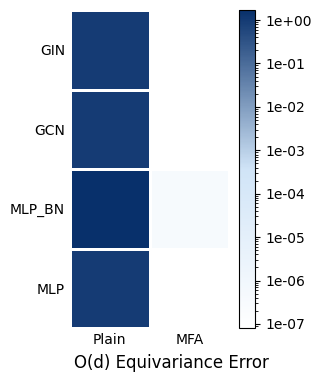

In [7]:
from visualize import visualize

visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='O(d) Equivariance Error', color='blue')

#### Comparison to FA, SFA and Improved FA

We compare our MFA method to FA, SFA (Stochastic Frame Averaging), and improved FA. Our improved FA uses first-order eigenvalue perturbation to alleviate the issue of degenerate averaging cases (See our paper Appendix H.3).

In [ ]:
from group_decorator import od_equivariant_puny_decorator, od_equivariant_sfa_decorator, od_equivariant_puny_improve_decorator

errors_puny, times_puny = od_equivariance_error(od_equivariant_puny_decorator)
errors_sfa, times_sfa = od_equivariance_error(od_equivariant_sfa_decorator)
errors_puny_improved, times_puny_improved = od_equivariance_error(od_equivariant_puny_improve_decorator)

100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


One can observe that our method requires less computation time compared to FA, SFA, and Improved FA. Additionally, we can visualize the equivariance errors and time cost using heatmaps to compare the performance of the different methods.

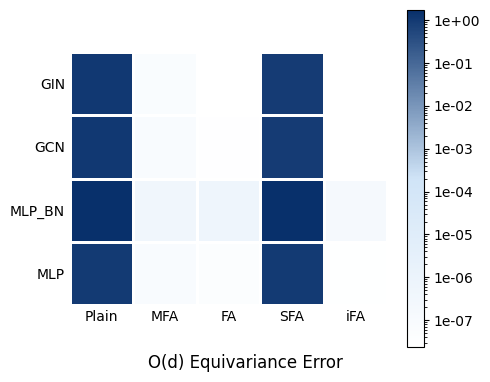

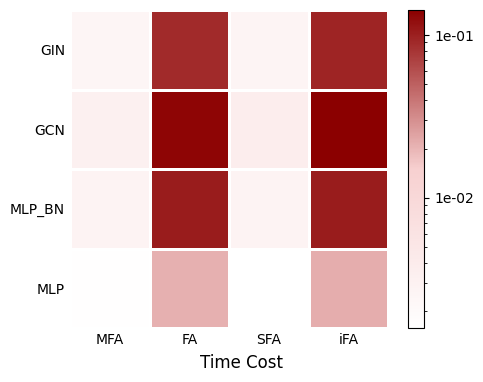

In [ ]:
from visualize import visualize

errors_all = np.concatenate([errors, errors_puny, errors_sfa, errors_puny_improved], axis=1)[:, [0, 1, 3, 5, 7]]
visualize(errors_all, figsize=(5, 4), x_labels=['Plain', 'MFA', 'FA', 'SFA', 'iFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='O(d) Equivariance Error', color='blue')

times_all = np.stack([times, times_puny, times_sfa, times_puny_improved], axis=1)
visualize(times_all, figsize=(5, 4), x_labels=['MFA', 'FA', 'SFA', 'iFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='Time Cost', color='red')

Our MFA, FA, and Improved FA (iFA) methods all achieve near-exact equivariance errors. The equivariance error for our MFA is slightly larger than that of FA and iFA, but it remains within the scale of $1\times 10^{-7}$. This minor discrepancy is due to computational errors during the Gram-Schmidt process. Nonetheless, MFA performs significantly better than the Plain (models without any equivariance method) and SFA models. Also, our MFA has much less time cost than FA and iFA. Additionally, we demonstrate that MFA and iFA are more robust than FA in handling degenerate cases.

#### $O(d)$-Equivariance Test with Degenerate Input

Consider generate random $n\times d$ data with repeated singular values to test the robustness of the methods.

In [ ]:
def generate_repeated_singular_values(d, n, repeats, rank):
    assert repeats <= rank <= d <= n
    Sigma = np.zeros((d, n))
    ind = 0
    if repeats > 0:
        val = np.abs(np.random.randn(1))
        for i in range(repeats):
            Sigma[i, i] = val
        ind = repeats
    if rank - repeats > 0:
        val = np.abs(np.random.randn(rank - repeats))
        for i in range(rank - repeats):
            Sigma[i + ind, i + ind] = val[i]
        ind = rank
    if d - rank > 0:
        for i in range(d - rank):
            Sigma[i + ind, i + ind] = 0

    return torch.FloatTensor(ortho_group.rvs(dim=d) @ Sigma @ ortho_group.rvs(dim=n)).transpose(0, 1)

Using $128\times 6$ samples, we generate features with 4 repeated singular values and 1 zero singular values to test the robustness of the methods.

In [ ]:
repeats = 4
rank = 4

In [ ]:
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import od_equivariant_decorator, od_equivariant_puny_decorator, od_equivariant_sfa_decorator, od_equivariant_puny_improve_decorator

def degenerate_od_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []
    times_MLP = []
    times_MLP_BN = []
    times_GCN = []
    times_GIN = []

    for _ in tqdm(range(trials)):
        pc = generate_repeated_singular_values(d, n, repeats, rank)
        transform = generate_Od_matrix(d)
        error_MLP, time_MLP = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)
        times_MLP.append(time_MLP)

        error_MLP_BN, time_MLP_BN = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)
        times_MLP_BN.append(time_MLP_BN)

        error_GCN, time_GCN = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)
        times_GCN.append(time_GCN)

        error_GIN, time_GIN = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)
        times_GIN.append(time_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()

    times_MLP = np.array(times_MLP).mean()
    times_MLP_BN = np.array(times_MLP_BN).mean()
    times_GCN = np.array(times_GCN).mean()
    times_GIN = np.array(times_GIN).mean()
    
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    times = np.array([times_MLP, times_MLP_BN, times_GCN, times_GIN])
    return errors, times


degenerate_errors, degenerate_times = degenerate_od_equivariance_error(od_equivariant_decorator)
degenerate_errors_puny, degenerate_times_puny = degenerate_od_equivariance_error(od_equivariant_puny_decorator)
degenerate_errors_sfa, degenerate_times_sfa = degenerate_od_equivariance_error(od_equivariant_sfa_decorator)
degenerate_errors_puny_improved, degenerate_times_puny_improved = degenerate_od_equivariance_error(od_equivariant_puny_improve_decorator)

  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\kruskallin\AppData\Local\Temp\ipykernel_16796\1063737706.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Sigma[i, i] = val
c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [02:35<00:00,  1.56s/it]


Now we visualize the equivariance errors and time cost using heatmaps.

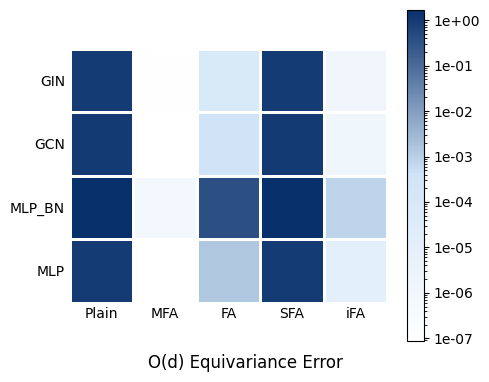

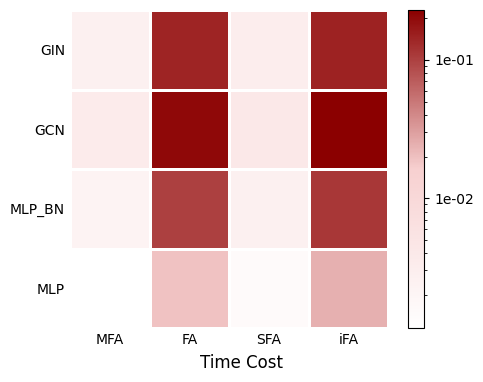

In [ ]:
from visualize import visualize

degenerate_errors_all = np.concatenate([degenerate_errors, degenerate_errors_puny, degenerate_errors_sfa, degenerate_errors_puny_improved], axis=1)[:, [0, 1, 3, 5, 7]]
visualize(degenerate_errors_all, figsize=(5, 4), x_labels=['Plain', 'MFA', 'FA', 'SFA', 'iFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='O(d) Equivariance Error', color='blue')

degenerate_times_all = np.stack([degenerate_times, degenerate_times_puny, degenerate_times_sfa, degenerate_times_puny_improved], axis=1)
visualize(degenerate_times_all, figsize=(5, 4), x_labels=['MFA', 'FA', 'SFA', 'iFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='Time Cost', color='red')

Considering both equivariance error and time cost, we find that our MFA method provides more robust results than SFA while requiring less computation time than FA and iFA.

In the sections below, we will repeat the equivariance tests by generating corresponding group actions and visualize the equivariance error for each group.

### $SO(d)$-Equivariance Test


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:06<00:00, 15.14it/s]


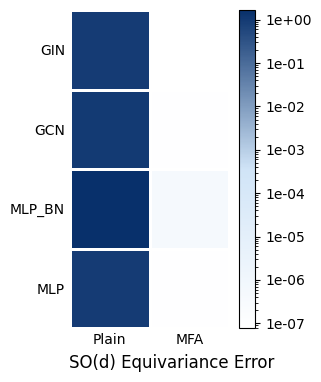

In [ ]:
import torch
from scipy.stats import special_ortho_group
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import sod_equivariant_decorator
from visualize import visualize

n = 128
d = 6
trials = 100

def generate_SOd_matrix(d):
    return torch.FloatTensor(special_ortho_group.rvs(d))

def sod_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_SOd_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = sod_equivariance_error(sod_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='SO(d) Equivariance Error', color='blue')


### $E(d)$-Equivariance Test


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:05<00:00, 16.91it/s]


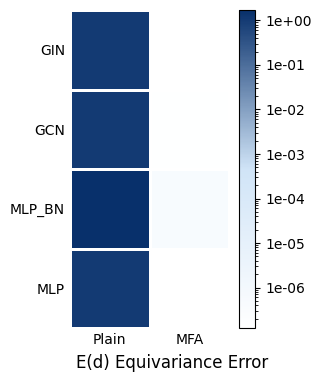

In [ ]:
import torch
from scipy.stats import ortho_group
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import ed_equivariant_decorator
from visualize import visualize

n = 128
d = 6
trials = 100

def generate_Od_matrix(d):
    return torch.FloatTensor(ortho_group.rvs(d))

def ed_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_Od_matrix(d)
        shift = torch.randn((n, 1))
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = sod_equivariance_error(ed_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='E(d) Equivariance Error', color='blue')


### $SE(d)$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:06<00:00, 15.76it/s]


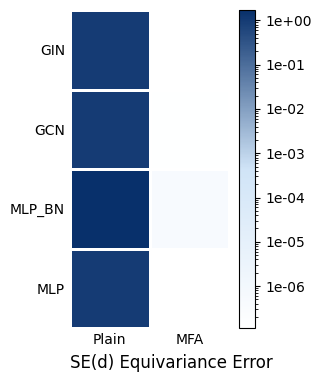

In [ ]:
import torch
from scipy.stats import special_ortho_group
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import sed_equivariant_decorator
from visualize import visualize

n = 128
d = 6
trials = 100

def generate_SOd_matrix(d):
    return torch.FloatTensor(special_ortho_group.rvs(d))

def sed_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_SOd_matrix(d)
        shift = torch.randn((n, 1))
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform, shift=shift)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = sod_equivariance_error(sed_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='SE(d) Equivariance Error', color='blue')


In the below two sections, we generate complex matrices for data and group actions to evaluate $U(d)$ and $SU(d)$ equivariance, and perform equivariance test using complex networks including MLP and MLP with Batch Normalization (BN).

### $U(d)$-Equivariance Test

100%|██████████| 100/100 [00:06<00:00, 15.58it/s]


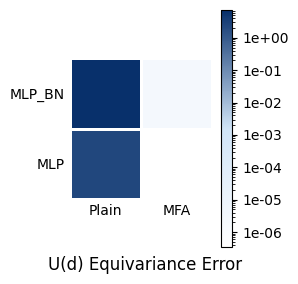

In [ ]:
import torch
from scipy.stats import unitary_group
import numpy as np
from tqdm import tqdm
from model import MLP_Complex, MLP_BN_Mish_Complex
from group_decorator import ud_equivariant_decorator
from visualize import visualize

n = 128
d = 6
trials = 100

def generate_Ud_matrix(d):
    return torch.from_numpy(unitary_group.rvs(d)).to(torch.complex64)

def ud_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d)) + torch.randn((n, d)) * 1j
        transform = generate_Ud_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP_Complex, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish_Complex, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = ud_equivariance_error(ud_equivariant_decorator)
visualize(errors, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='U(d) Equivariance Error', color='blue')


### $SU(d)$-Equivariance Test

100%|██████████| 100/100 [00:06<00:00, 14.33it/s]


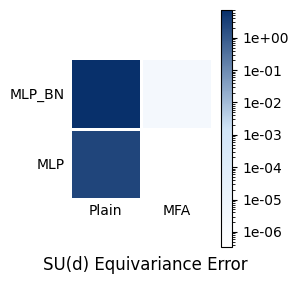

In [ ]:
import torch
from scipy.stats import unitary_group
import numpy as np
from tqdm import tqdm
from model import MLP_Complex, MLP_BN_Mish_Complex
from group_decorator import sud_equivariant_decorator
from visualize import visualize

n = 128
d = 6
trials = 100

def generate_SUd_matrix(d):
    Q = unitary_group.rvs(d)
    det = np.linalg.det(Q)
    Q = Q / (det ** (1 / d))
    return torch.from_numpy(Q).to(torch.complex64)

def sud_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d)) + torch.randn((n, d)) * 1j
        transform = generate_SUd_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP_Complex, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish_Complex, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sud_equivariance_error(sud_equivariant_decorator)
visualize(errors, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='SU(d) Equivariance Error', color='blue')


In the below two sections, we generate matrices for data with a dimension of $4$ for $O(1,3)$ and $SO(1,3)$.

### $O(1,d-1)$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:05<00:00, 17.02it/s]


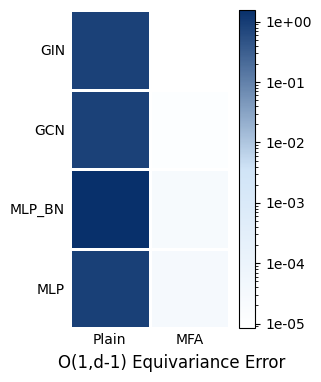

In [4]:
import torch
from scipy.stats import ortho_group
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import o1d_equivariant_decorator
from visualize import visualize

n = 128
d = 4
trials = 100

def boost_matrix(beta):
    beta = np.asarray(beta)
    beta_norm = np.linalg.norm(beta)
    gamma = 1 / np.sqrt(1 - beta_norm ** 2)

    B = np.eye(4)
    B[0, 0] = gamma
    B[0, 1:] = -gamma * beta
    B[1:, 0] = -gamma * beta
    B[1:, 1:] += (gamma - 1) * np.outer(beta, beta) / beta_norm ** 2
    return B


def generate_O13_matrix(d):
    R = ortho_group.rvs(d - 1).T
    while True:
        beta = np.random.uniform(-0.99, 0.99, 3)
        if np.linalg.norm(beta) < 1:
            break

    B = boost_matrix(beta)
    L = np.eye(4)
    L[1:, 1:] = R
    L = B @ L
    return torch.FloatTensor(L)


def o1d_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_O13_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = o1d_equivariance_error(o1d_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='O(1,d-1) Equivariance Error', color='blue')


### $SO(1,d-1)$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:05<00:00, 16.73it/s]


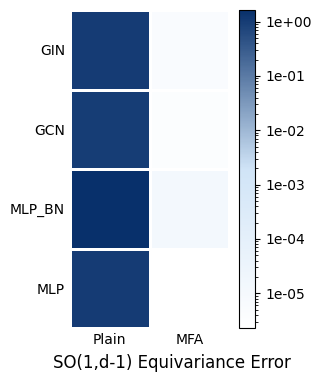

In [6]:
import torch
from scipy.stats import special_ortho_group
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import so1d_equivariant_decorator
from visualize import visualize

n = 128
d = 4
trials = 100

def boost_matrix(beta):
    beta = np.asarray(beta)
    beta_norm = np.linalg.norm(beta)
    gamma = 1 / np.sqrt(1 - beta_norm ** 2)

    B = np.eye(4)
    B[0, 0] = gamma
    B[0, 1:] = -gamma * beta
    B[1:, 0] = -gamma * beta
    B[1:, 1:] += (gamma - 1) * np.outer(beta, beta) / beta_norm ** 2
    return B


def generate_SO13_matrix(d):
    R = special_ortho_group.rvs(d - 1).T
    while True:
        beta = np.random.uniform(-0.99, 0.99, 3)
        if np.linalg.norm(beta) < 1:
            break

    B = boost_matrix(beta)
    L = np.eye(4)
    L[1:, 1:] = R
    L = B @ L
    return torch.FloatTensor(L)


def so1d_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_SO13_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = so1d_equivariance_error(so1d_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='SO(1,d-1) Equivariance Error', color='blue')


### $GL(d,\mathbb{R})$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


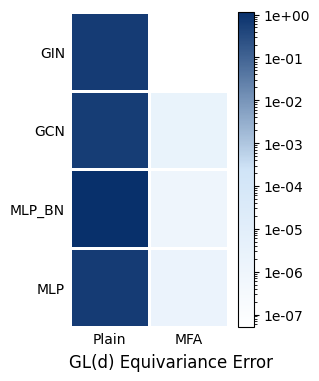

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import gld_equivariant_decorator
from visualize import visualize

n = 128
d = 3
trials = 100

def generate_GLd_matrix(d):
    while True:
        matrix = torch.randn(d, d)
        det = torch.det(matrix)
        if torch.abs(det) > 1e-3:
            return matrix.T


def gld_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        while True:
            pc = torch.randn((n, d))
            if torch.linalg.matrix_rank(pc) == d:
                break
        transform = generate_GLd_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = gld_equivariance_error(gld_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='GL(d) Equivariance Error', color='blue')

### $SL(d,\mathbb{R})$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:143: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.fc1.weight, std=1e-6)
100%|██████████| 100/100 [00:05<00:00, 19.67it/s]


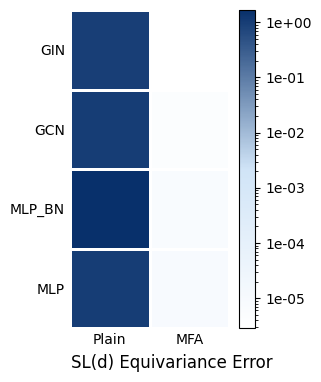

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from model import MLP, MLP_BN_Mish, GCN, GIN
from group_decorator import sld_equivariant_decorator
from visualize import visualize

n = 128
d = 3
trials = 100

def generate_SLd_matrix(d):
    while True:
        matrix = torch.randn(d, d)
        det = torch.det(matrix)
        if det != 0:
            matrix[0, :] *= 1 / det
            if torch.det(matrix) != 1.0:
                continue
            return matrix.T


def sld_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []
    errors_GCN = []
    errors_GIN = []

    for _ in tqdm(range(trials)):
        while True:
            pc = torch.randn((n, d))
            if torch.linalg.matrix_rank(pc) == d:
                break
        transform = generate_SLd_matrix(d)
        error_MLP, _ = compute_equivariance_error(MLP, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN, _ = compute_equivariance_error(MLP_BN_Mish, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

        error_GCN, _ = compute_equivariance_error(GCN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GCN.append(error_GCN)

        error_GIN, _ = compute_equivariance_error(GIN, pc, d, equivariance_error_right_multiply, decorator, transform=transform)
        errors_GIN.append(error_GIN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors_GCN = torch.FloatTensor(errors_GCN).mean(0).numpy()
    errors_GIN = torch.FloatTensor(errors_GIN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN, errors_GCN, errors_GIN], axis=0)
    return errors

errors = sld_equivariance_error(sld_equivariant_decorator)
visualize(errors, figsize=(3, 4), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN', 'GCN', 'GIN'], title='SL(d) Equivariance Error', color='blue')

In the sections below, we employ MLP to transform both the first and second dimensions of the data to test $S_n$ quivariance and its product groups, where $n$ and $d$ both affect parameters of the model.

In [4]:
def compute_equivariance_error(model, pc, d, n, error_func, group_decorator, transform=None, transform2=None, shift=None):
    m = model(d, n)
    origin = error_func(m, pc, transform, transform2, shift)
    
    f = model(d, n)
    f.forward = group_decorator(f.forward)
    frame = error_func(f, pc, transform, transform2, shift)
    return origin, frame

### $S_n$-Equivariance Test

For $S_n$ we use lexicographical sorting to generate minimal frame.

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)
100%|██████████| 100/100 [00:00<00:00, 119.99it/s]


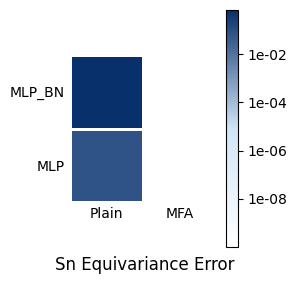

In [6]:
import torch
import numpy as np
from tqdm import tqdm
from model import MLP_S, MLP_S_BN_Mish
from group_decorator import sn_equivariant_decorator
from visualize import visualize

n = 32
d = 3
trials = 100


def generate_Sn_matrix(n):
    I = np.eye(n)
    p = np.random.permutation(n)
    P = I[p]
    return torch.FloatTensor(P)


def sn_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_Sn_matrix(n)
        error_MLP = compute_equivariance_error(MLP_S, pc, d, n, equivariance_error_left_multiply, decorator, transform=transform)
        errors_MLP.append(error_MLP)

        error_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, d, n, equivariance_error_left_multiply, decorator, transform=transform)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sn_equivariance_error(sn_equivariant_decorator)
# Error is very close to 0; Add 1e-10 to error to adjust the number scale.
visualize(errors + 1e-10, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn Equivariance Error', color='blue')

### $S_n\times O(d)$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)
100%|██████████| 100/100 [00:02<00:00, 40.96it/s]


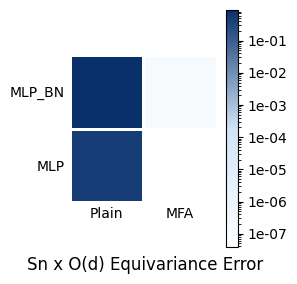

In [13]:
import torch
import numpy as np
from scipy.stats import ortho_group
from tqdm import tqdm
from model import MLP_S, MLP_S_BN_Mish
from group_decorator import sn_od_equivariant_decorator
from visualize import visualize

n = 32
d = 3
trials = 100


def generate_Od_matrix(d):
    return torch.FloatTensor(ortho_group.rvs(d))


def generate_Sn_matrix(n):
    I = np.eye(n)
    p = np.random.permutation(n)
    P = I[p]
    return torch.FloatTensor(P)


def sn_od_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_Sn_matrix(n)
        transform2 = generate_Od_matrix(d)
        error_MLP = compute_equivariance_error(MLP_S, pc, d, n, equivariance_error_left_right_multiply, decorator, transform=transform, transform2=transform2)
        errors_MLP.append(error_MLP)

        error_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, d, n, equivariance_error_left_right_multiply, decorator, transform=transform, transform2=transform2)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sn_od_equivariance_error(sn_od_equivariant_decorator)
visualize(errors, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn x O(d) Equivariance Error', color='blue')

We can also consider a highly symmetric case.

c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)


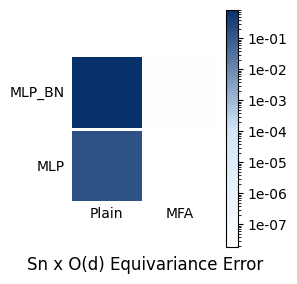

In [14]:
pc = torch.FloatTensor([[1, 0, 0], [-1, 0, 0], [0, 1, 0], [0, -1, 0], [0, 0, 1], [0, 0, -1]])
transform = generate_Sn_matrix(6)
transform2 = generate_Od_matrix(3)
error_symmetric_MLP = compute_equivariance_error(MLP_S, pc, 3, 6, equivariance_error_left_right_multiply, sn_od_equivariant_decorator, transform=transform, transform2=transform2)
error_symmetric_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, 3, 6, equivariance_error_left_right_multiply, sn_od_equivariant_decorator, transform=transform, transform2=transform2)
error_symmetric = np.stack([torch.FloatTensor(error_symmetric_MLP).numpy(), torch.FloatTensor(error_symmetric_MLP_BN).numpy()], axis=0)
visualize(error_symmetric, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn x O(d) Equivariance Error', color='blue')

### $S_n\times SO(d)$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)
100%|██████████| 100/100 [00:03<00:00, 32.40it/s]


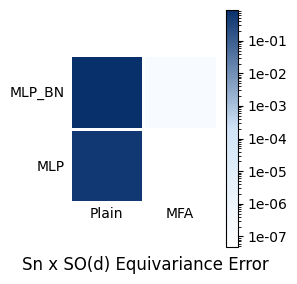

In [3]:
import torch
import numpy as np
from scipy.stats import special_ortho_group
from tqdm import tqdm
from model import MLP_S, MLP_S_BN_Mish
from group_decorator import sn_sod_equivariant_decorator
from visualize import visualize

n = 32
d = 3
trials = 100


def generate_SOd_matrix(d):
    return torch.FloatTensor(special_ortho_group.rvs(d))


def generate_Sn_matrix(n):
    I = np.eye(n)
    p = np.random.permutation(n)
    P = I[p]
    return torch.FloatTensor(P)


def sn_sod_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_Sn_matrix(n)
        transform2 = generate_SOd_matrix(d)
        error_MLP = compute_equivariance_error(MLP_S, pc, d, n, equivariance_error_left_right_multiply, decorator, transform=transform, transform2=transform2)
        errors_MLP.append(error_MLP)

        error_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, d, n, equivariance_error_left_right_multiply, decorator, transform=transform, transform2=transform2)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sn_sod_equivariance_error(sn_sod_equivariant_decorator)
visualize(errors, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn x SO(d) Equivariance Error', color='blue')

### $S_n\times O(1,d-1)$-Equivariance Test

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\kruskallin\Desktop\Miscellaneous\research\gfa\equivariant_test\model.py:55: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(self.fc1.weight)
100%|██████████| 100/100 [00:02<00:00, 35.40it/s]


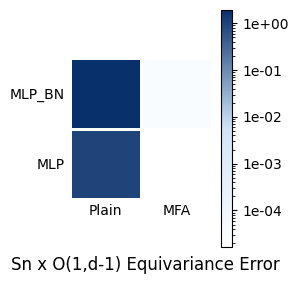

In [12]:
import torch
import numpy as np
from scipy.stats import ortho_group
from tqdm import tqdm
from model import MLP_S, MLP_S_BN_Mish
from group_decorator import sn_o1d_equivariant_decorator
from visualize import visualize

n = 32
d = 4
trials = 100

def boost_matrix(beta):
    beta = np.asarray(beta)
    beta_norm = np.linalg.norm(beta)
    gamma = 1 / np.sqrt(1 - beta_norm ** 2)

    B = np.eye(4)
    B[0, 0] = gamma
    B[0, 1:] = -gamma * beta
    B[1:, 0] = -gamma * beta
    B[1:, 1:] += (gamma - 1) * np.outer(beta, beta) / beta_norm ** 2
    return B


def generate_O13_matrix(d):
    R = ortho_group.rvs(d - 1).T
    while True:
        beta = np.random.uniform(-0.99, 0.99, 3)
        if np.linalg.norm(beta) < 1:
            break

    B = boost_matrix(beta)
    L = np.eye(4)
    L[1:, 1:] = R
    L = B @ L
    return torch.FloatTensor(L)


def generate_Sn_matrix(n):
    I = np.eye(n)
    p = np.random.permutation(n)
    P = I[p]
    return torch.FloatTensor(P)


def sn_o1d_equivariance_error(decorator):
    errors_MLP = []
    errors_MLP_BN = []

    for _ in tqdm(range(trials)):
        pc = torch.randn((n, d))
        transform = generate_Sn_matrix(n)
        transform2 = generate_O13_matrix(d)
        error_MLP = compute_equivariance_error(MLP_S, pc, d, n, equivariance_error_left_right_multiply, decorator, transform=transform, transform2=transform2)
        errors_MLP.append(error_MLP)

        error_MLP_BN = compute_equivariance_error(MLP_S_BN_Mish, pc, d, n, equivariance_error_left_right_multiply, decorator, transform=transform, transform2=transform2)
        errors_MLP_BN.append(error_MLP_BN)

    errors_MLP = torch.FloatTensor(errors_MLP).mean(0).numpy()
    errors_MLP_BN = torch.FloatTensor(errors_MLP_BN).mean(0).numpy()
    errors = np.stack([errors_MLP, errors_MLP_BN], axis=0)
    return errors

errors = sn_o1d_equivariance_error(sn_o1d_equivariant_decorator)
visualize(errors, figsize=(3, 3), x_labels=['Plain', 'MFA'], y_labels=['MLP', 'MLP_BN'], title='Sn x O(1,d-1) Equivariance Error', color='blue')